In [1]:
import cv2
import os
import numpy as np
import torch
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# !unzip /content/gdrive/MyDrive/Dissertation/Epic_vid_balanced_new_7Sept.zip

In [5]:
# video_df = pd.read_csv('/content/balanced_dataset_details_7thSept.csv')
video_df = pd.read_csv("D:\\balanced_dataset_details_7thSept.csv")

In [6]:
# video_df_sample = video_df.sample(frac=0.05, random_state=42)

In [7]:
# Step 1: Split the data into training + validation and test sets
train_val_data, test_df = train_test_split(video_df, test_size=0.2, random_state=42)  # 20% for test set

# Step 2: Split the training data into training and validation sets
train_df, val_df = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 25% of the remaining data for validation

# The splits result in:
# - 60% training
# - 20% validation
# - 20% test 

In [8]:
# train_df, test_df = train_test_split(video_df_sample, test_size=0.2, random_state=42)

In [9]:
# Step 4: Define the PyTorch Dataset class for loading videos and scores
class VideoQualityDataset(Dataset):
    def __init__(self, data_frame, video_folder, num_segments=3, transform=None):
        """
        Custom dataset for video quality scoring.

        Args:
        - data_frame (pd.DataFrame): DataFrame containing video names and scores.
        - video_folder (str): Path to the folder containing videos.
        - num_segments (int): Number of segments to divide each video into.
        - transform (torchvision.transforms): Transformations to apply to frames.
        """
        self.data_frame = data_frame
        self.video_folder = video_folder
        self.num_segments = num_segments
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get the video name and its corresponding score
        video_name = self.data_frame.iloc[idx]['Video Name']
        label = self.data_frame.iloc[idx]['Quality Score']

        # Construct full path to the video file
        video_path = os.path.join(self.video_folder, video_name)

        # Extract frames from the video
        frames = self.extract_frames(video_path, self.num_segments, self.transform)

        return frames, torch.tensor(label, dtype=torch.float32)

    def extract_frames(self, video_path, num_segments=3, transform=None):
        """
        Extracts frames from a video file for TSN input.

        Args:
        - video_path (str): Path to the video file.
        - num_segments (int): Number of segments to divide the video into.
        - transform (torchvision.transforms): Transformations to apply to frames.

        Returns:
        - frames (torch.Tensor): Tensor of shape (num_segments, channels, height, width).
        """
        # Open the video file
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise IOError(f"Cannot open video file: {video_path}")

        # Get the total number of frames in the video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate the segment length
        segment_length = total_frames // num_segments

        frames = []

        for i in range(num_segments):
            # Calculate the frame index to extract
            frame_idx = i * segment_length

            # Set the current frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

            # Read the frame
            ret, frame = cap.read()
            if not ret:
                continue

            # Convert the frame from BGR to RGB format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Apply transformations (e.g., resize, normalize)
            if transform is not None:
                frame = transform(frame)

            frames.append(frame)

        cap.release()

        # Stack frames into a tensor
        frames = torch.stack(frames)

        return frames

# Step 5: Define the data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize frames to the input size required by the model (e.g., 224x224)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet means and stds
])

# Step 6: Initialize training and testing datasets and loaders
video_folder = "D:\\Epic_vid_balanced_new_7Sept"  # Replace with the folder containing your videos

train_dataset = VideoQualityDataset(train_df, video_folder, num_segments=3, transform=transform)
val_dataset = VideoQualityDataset(val_df, video_folder, num_segments=3, transform=transform)
test_dataset = VideoQualityDataset(test_df, video_folder, num_segments=3, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
import torch.nn as nn
import torchvision.models as models

class TSNForQualityScore(nn.Module):
    def __init__(self, base_model='resnet50', num_segments=3):
        super(TSNForQualityScore, self).__init__()

        self.num_segments = num_segments

        # Load a pre-trained model (e.g., ResNet50)
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Correct the weights handling

        # Remove the final fully connected layer
        self.base_model = nn.Sequential(*list(resnet.children())[:-1])

        # Get the number of input features to the fully connected layer
        in_features = resnet.fc.in_features  # Access the correct 'in_features' from the 'fc' layer

        # Add a new fully connected layer for regression (predicting quality score)
        self.fc = nn.Linear(in_features, 1)

        # Sigmoid activation to ensure output is between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, num_segments, channels, height, width)
        batch_size = x.size(0)

        # Process each segment through the base model
        x = x.view(-1, x.size(2), x.size(3), x.size(4))  # Reshape to process all segments
        x = self.base_model(x)
        x = x.view(batch_size, self.num_segments, -1).mean(dim=1)  # Average over segments

        # Final fully connected layer for quality score prediction
        x = self.fc(x)
        x = self.sigmoid(x)

        return x


In [11]:
# Training and evaluation metrics
def calculate_metrics(outputs, targets):
    """
    Calculate MAE and Pearson correlation between predicted and actual targets.
    """
    # Detach tensors and convert to numpy for metric calculations
    outputs = outputs.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()

    # Calculate MAE
    mae = mean_absolute_error(targets, outputs)
    r2 = r2_score(targets, outputs)

    # # Calculate Pearson correlation
    # if len(targets) > 1:
    #     pearson_corr, _ = pearsonr(targets, outputs)
    # else:
    #     pearson_corr = float('nan')  # Pearson's correlation is undefined for single-element arrays

    # Calculate RMSE
    rmse = np.sqrt(np.mean((targets - outputs) ** 2))

    return mae, r2, rmse

In [12]:
import torch.optim as optim

# Initialize model, loss function, and optimizer
model = TSNForQualityScore(base_model='resnet50', num_segments=3).to(device)
criterion = nn.MSELoss()  # or nn.L1Loss() for MAE
optimizer = optim.Adam(model.parameters(), lr=0.001)

# dictionary to store error metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'train_rmse': [],
    'val_rmse': [],
    'train_R2': [],
    'val_R2': []
}

# variables for early stopping
best_val_loss = float('inf')
patience = 5
counter = 0

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_preds, train_targets = [], []
    # print(f"Epoch [{epoch+1}/{num_epochs}]")

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.view(-1)

        # Collect predictions and targets for MAE and Pearson's r calculations
        train_preds.extend(outputs.cpu().detach().numpy())
        train_targets.extend(targets.cpu().detach().numpy())

        # Compute loss
        loss = criterion(outputs, targets)
        loss.backward()

        # Update parameters
        optimizer.step()

        running_loss += loss.item()

    # Calculate metrics for the training set
    mae_train, pearson_train, rmse_train = calculate_metrics(torch.tensor(train_preds), torch.tensor(train_targets))

    # Store training metrics
    history['train_loss'].append(running_loss / len(train_loader))
    history['train_mae'].append(mae_train)
    history['train_R2'].append(pearson_train)
    history['train_rmse'].append(rmse_train)

    # Validation evaluation after each epoch
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            outputs = outputs.view(-1)

            val_preds.extend(outputs.cpu().detach().numpy())
            val_targets.extend(targets.cpu().detach().numpy())

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Calculate validation metrics
    mae_val, pearson_val, rmse_val = calculate_metrics(torch.tensor(val_preds), torch.tensor(val_targets))

    # Store validation metrics
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_mae'].append(mae_val)
    history['val_R2'].append(pearson_val)
    history['val_rmse'].append(rmse_val)

    # Print both training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] completed.")
    print(f"Training Loss: {history['train_loss'][-1]:.4f}, Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Training MAE: {history['train_mae'][-1]:.4f}, Validation MAE: {history['val_mae'][-1]:.4f}")
    print(f"Training R2: {history['train_R2'][-1]:.4f}, Validation R2: {history['val_R2'][-1]:.4f}")
    print(f"Training RMSE: {history['train_rmse'][-1]:.4f}, Validation RMSE: {history['val_rmse'][-1]:.4f}")

    # early stopping
    if history['val_loss'][-1] < best_val_loss:
        best_val_loss = history['val_loss'][-1]
        counter = 0  # Reset counter if validation loss improves
        # Save the best model if necessary
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


    # # Simplified output for training loss and metrics
    # print(f"Epoch [{epoch+1}/{num_epochs}] completed. Loss: {running_loss / len(train_loader):.4f}, "
    #       f"MAE: {mae_train:.4f}, Pearson's r: {pearson_train:.4f}, RMSE: {rmse_train:.4f}")

Training Epoch 1: 100%|██████████| 315/315 [1:10:15<00:00, 13.38s/it]


Epoch [1/50] completed.
Training Loss: 0.0269, Validation Loss: 0.0196
Training MAE: 0.1202, Validation MAE: 0.0914
Training Pearson's r: 0.8685, Validation Pearson's r: 0.9251
Training RMSE: 0.1642, Validation RMSE: 0.1399


Training Epoch 2: 100%|██████████| 315/315 [47:19<00:00,  9.02s/it]


Epoch [2/50] completed.
Training Loss: 0.0182, Validation Loss: 0.0183
Training MAE: 0.0997, Validation MAE: 0.0906
Training Pearson's r: 0.9120, Validation Pearson's r: 0.9194
Training RMSE: 0.1348, Validation RMSE: 0.1351


Training Epoch 3: 100%|██████████| 315/315 [47:36<00:00,  9.07s/it]


Epoch [3/50] completed.
Training Loss: 0.0150, Validation Loss: 0.0126
Training MAE: 0.0903, Validation MAE: 0.0829
Training Pearson's r: 0.9280, Validation Pearson's r: 0.9381
Training RMSE: 0.1223, Validation RMSE: 0.1122


Training Epoch 4: 100%|██████████| 315/315 [47:26<00:00,  9.04s/it]


Epoch [4/50] completed.
Training Loss: 0.0123, Validation Loss: 0.0146
Training MAE: 0.0814, Validation MAE: 0.0856
Training Pearson's r: 0.9410, Validation Pearson's r: 0.9371
Training RMSE: 0.1110, Validation RMSE: 0.1208


Training Epoch 5: 100%|██████████| 315/315 [53:54<00:00, 10.27s/it] 


Epoch [5/50] completed.
Training Loss: 0.0107, Validation Loss: 0.0118
Training MAE: 0.0747, Validation MAE: 0.0762
Training Pearson's r: 0.9489, Validation Pearson's r: 0.9451
Training RMSE: 0.1035, Validation RMSE: 0.1085


Training Epoch 6: 100%|██████████| 315/315 [51:54<00:00,  9.89s/it]


Epoch [6/50] completed.
Training Loss: 0.0098, Validation Loss: 0.0235
Training MAE: 0.0718, Validation MAE: 0.0961
Training Pearson's r: 0.9534, Validation Pearson's r: 0.8941
Training RMSE: 0.0989, Validation RMSE: 0.1532


Training Epoch 7: 100%|██████████| 315/315 [51:02<00:00,  9.72s/it]


Epoch [7/50] completed.
Training Loss: 0.0099, Validation Loss: 0.0108
Training MAE: 0.0724, Validation MAE: 0.0661
Training Pearson's r: 0.9530, Validation Pearson's r: 0.9501
Training RMSE: 0.0994, Validation RMSE: 0.1040


Training Epoch 8: 100%|██████████| 315/315 [48:44<00:00,  9.28s/it]


Epoch [8/50] completed.
Training Loss: 0.0086, Validation Loss: 0.0088
Training MAE: 0.0661, Validation MAE: 0.0671
Training Pearson's r: 0.9594, Validation Pearson's r: 0.9588
Training RMSE: 0.0925, Validation RMSE: 0.0938


Training Epoch 9: 100%|██████████| 315/315 [48:30<00:00,  9.24s/it]


Epoch [9/50] completed.
Training Loss: 0.0085, Validation Loss: 0.0089
Training MAE: 0.0663, Validation MAE: 0.0637
Training Pearson's r: 0.9595, Validation Pearson's r: 0.9576
Training RMSE: 0.0924, Validation RMSE: 0.0944


Training Epoch 10: 100%|██████████| 315/315 [49:05<00:00,  9.35s/it]


Epoch [10/50] completed.
Training Loss: 0.0076, Validation Loss: 0.0089
Training MAE: 0.0623, Validation MAE: 0.0647
Training Pearson's r: 0.9643, Validation Pearson's r: 0.9582
Training RMSE: 0.0869, Validation RMSE: 0.0944


Training Epoch 11: 100%|██████████| 315/315 [48:40<00:00,  9.27s/it]


Epoch [11/50] completed.
Training Loss: 0.0072, Validation Loss: 0.0122
Training MAE: 0.0612, Validation MAE: 0.0839
Training Pearson's r: 0.9658, Validation Pearson's r: 0.9518
Training RMSE: 0.0851, Validation RMSE: 0.1103


Training Epoch 12: 100%|██████████| 315/315 [48:35<00:00,  9.26s/it]


Epoch [12/50] completed.
Training Loss: 0.0065, Validation Loss: 0.0081
Training MAE: 0.0577, Validation MAE: 0.0621
Training Pearson's r: 0.9695, Validation Pearson's r: 0.9604
Training RMSE: 0.0804, Validation RMSE: 0.0901


Training Epoch 13: 100%|██████████| 315/315 [48:39<00:00,  9.27s/it]


Epoch [13/50] completed.
Training Loss: 0.0060, Validation Loss: 0.0112
Training MAE: 0.0553, Validation MAE: 0.0654
Training Pearson's r: 0.9719, Validation Pearson's r: 0.9532
Training RMSE: 0.0772, Validation RMSE: 0.1058


Training Epoch 14: 100%|██████████| 315/315 [48:41<00:00,  9.28s/it]


Epoch [14/50] completed.
Training Loss: 0.0061, Validation Loss: 0.0072
Training MAE: 0.0558, Validation MAE: 0.0615
Training Pearson's r: 0.9714, Validation Pearson's r: 0.9655
Training RMSE: 0.0778, Validation RMSE: 0.0849


Training Epoch 15: 100%|██████████| 315/315 [48:43<00:00,  9.28s/it]


Epoch [15/50] completed.
Training Loss: 0.0058, Validation Loss: 0.0147
Training MAE: 0.0544, Validation MAE: 0.0857
Training Pearson's r: 0.9726, Validation Pearson's r: 0.9397
Training RMSE: 0.0763, Validation RMSE: 0.1213


Training Epoch 16: 100%|██████████| 315/315 [48:53<00:00,  9.31s/it]


Epoch [16/50] completed.
Training Loss: 0.0059, Validation Loss: 0.0137
Training MAE: 0.0548, Validation MAE: 0.0884
Training Pearson's r: 0.9722, Validation Pearson's r: 0.9342
Training RMSE: 0.0768, Validation RMSE: 0.1172


Training Epoch 17: 100%|██████████| 315/315 [48:47<00:00,  9.29s/it]


Epoch [17/50] completed.
Training Loss: 0.0065, Validation Loss: 0.0065
Training MAE: 0.0572, Validation MAE: 0.0552
Training Pearson's r: 0.9696, Validation Pearson's r: 0.9688
Training RMSE: 0.0803, Validation RMSE: 0.0805


Training Epoch 18: 100%|██████████| 315/315 [48:41<00:00,  9.27s/it]


Epoch [18/50] completed.
Training Loss: 0.0051, Validation Loss: 0.0097
Training MAE: 0.0508, Validation MAE: 0.0713
Training Pearson's r: 0.9760, Validation Pearson's r: 0.9581
Training RMSE: 0.0715, Validation RMSE: 0.0985


Training Epoch 19: 100%|██████████| 315/315 [1:18:01<00:00, 14.86s/it]


Epoch [19/50] completed.
Training Loss: 0.0041, Validation Loss: 0.0079
Training MAE: 0.0462, Validation MAE: 0.0604
Training Pearson's r: 0.9806, Validation Pearson's r: 0.9662
Training RMSE: 0.0643, Validation RMSE: 0.0891


Training Epoch 20: 100%|██████████| 315/315 [49:01<00:00,  9.34s/it]


Epoch [20/50] completed.
Training Loss: 0.0041, Validation Loss: 0.0065
Training MAE: 0.0456, Validation MAE: 0.0580
Training Pearson's r: 0.9806, Validation Pearson's r: 0.9698
Training RMSE: 0.0642, Validation RMSE: 0.0808


Training Epoch 21: 100%|██████████| 315/315 [50:31<00:00,  9.62s/it]


Epoch [21/50] completed.
Training Loss: 0.0039, Validation Loss: 0.0079
Training MAE: 0.0443, Validation MAE: 0.0584
Training Pearson's r: 0.9816, Validation Pearson's r: 0.9621
Training RMSE: 0.0626, Validation RMSE: 0.0891


Training Epoch 22: 100%|██████████| 315/315 [50:34<00:00,  9.63s/it]


Epoch [22/50] completed.
Training Loss: 0.0094, Validation Loss: 0.0095
Training MAE: 0.0669, Validation MAE: 0.0678
Training Pearson's r: 0.9555, Validation Pearson's r: 0.9537
Training RMSE: 0.0968, Validation RMSE: 0.0975
Early stopping triggered at epoch 22


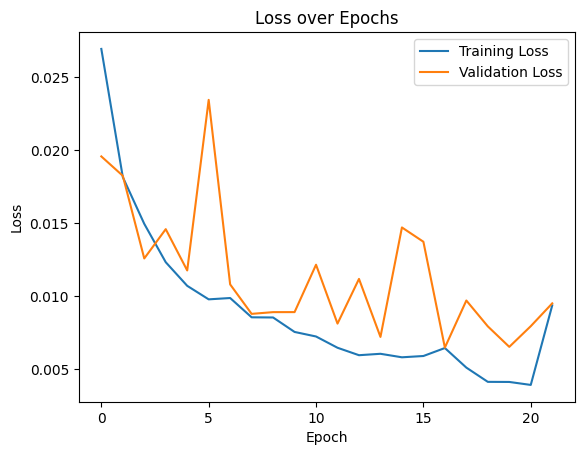

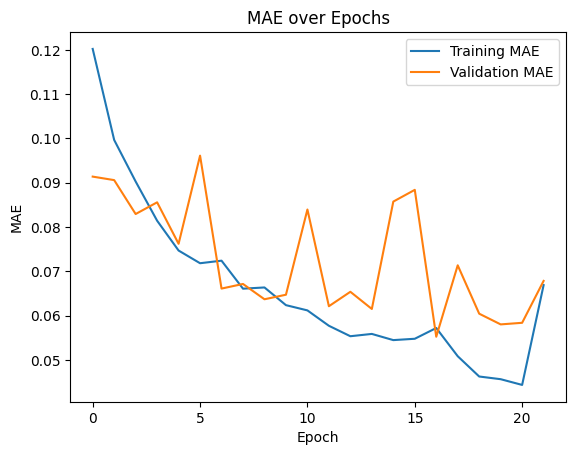

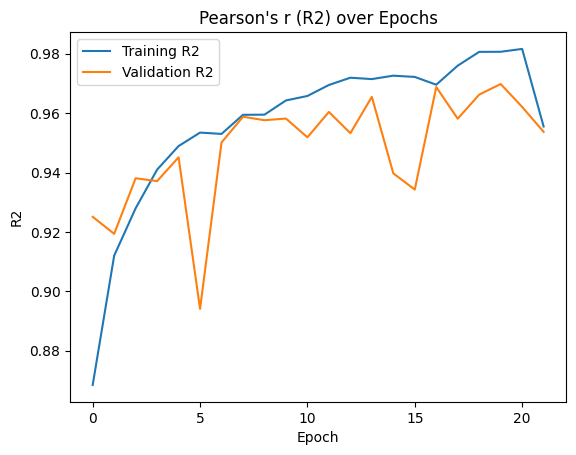

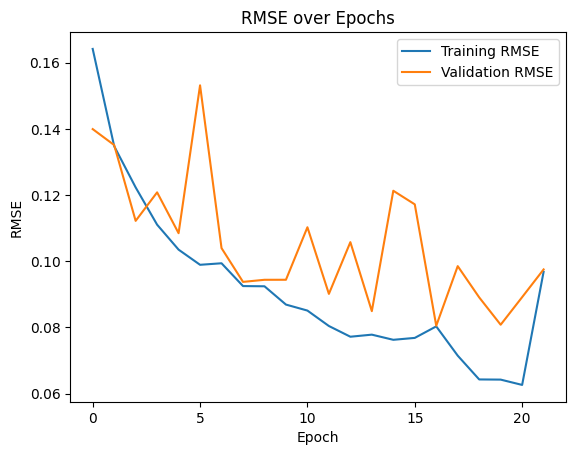

In [13]:
# Plot training and validation loss
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history['train_mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()
plt.show()

# Plot training and validation R2
plt.plot(history['train_R2'], label='Training R2')
plt.plot(history['val_R2'], label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.title("R2 over Epochs")
plt.legend()
plt.show()

# Plot training and validation RMSE
plt.plot(history['train_rmse'], label='Training RMSE')
plt.plot(history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title("RMSE over Epochs")
plt.legend()
plt.show()

In [14]:
# # Get the number of epochs
# epochs = range(1, num_epochs + 1)

# plt.figure(figsize=(10, 6))

# # Plot training errors
# plt.plot(epochs, history['train_loss'], label='Training Loss')
# plt.plot(epochs, history['train_mae'], label='Training MAE')
# plt.plot(epochs, history['train_rmse'], label='Training RMSE')

# # Plot validation errors
# plt.plot(epochs, history['val_loss'], label='Validation Loss', linestyle='--')
# plt.plot(epochs, history['val_mae'], label='Validation MAE', linestyle='--')
# plt.plot(epochs, history['val_rmse'], label='Validation RMSE', linestyle='--')

# plt.xlabel('Epochs')
# plt.ylabel('Error')
# plt.title('Training and Validation Errors')
# plt.legend()
# plt.show()

In [15]:
# Evaluate on the test set after all epochs are done
model.eval()
test_loss = 0.0
test_preds, test_targets = [], []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing on Final Model"):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.view(-1)  # Flatten output to match the target size

        # Collect predictions and targets for MAE and Pearson's r calculations
        test_preds.extend(outputs.cpu().detach().numpy())
        test_targets.extend(targets.cpu().detach().numpy())

        # Compute loss
        loss = criterion(outputs, targets)
        test_loss += loss.item()

# Calculate metrics for the test set
mae_test, pearson_test, rmse_test = calculate_metrics(torch.tensor(test_preds), torch.tensor(test_targets))

# Print the test loss and metrics
print(f"\nTest Loss: {test_loss / len(test_loader):.4f}"
      f"\nMAE: {mae_test:.4f} \nR2: {pearson_test:.4f} \nRMSE: {rmse_test:.4f}")

Testing on Final Model: 100%|██████████| 105/105 [10:23<00:00,  5.94s/it]


Test Loss: 0.0098
MAE: 0.0673 
Pearson's r: 0.9529 
RMSE: 0.0989


In [16]:
torch.save(model.state_dict(), 'latest_model.pth')